# COVID-19 DETECTION FROM X-RAYS

This notebook builds and train pretrained resnet50 model for covid-19 detection from x-ray images. The dataset is curated by Dr. Joseph Cohen, a postdoctoral fellow at the University of Montreal. We collected the data from the following github repo: https://github.com/ieee8023/covid-chestxray-dataset. The dataset contains chest xrays from covid-19 patients and normal individuals. 

**Import statements**

In [1]:
import itertools
import os
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import cv2
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

**Set random seed of numpy & tensorflow**

In [2]:
numpy_seed = 0
np.random.seed(numpy_seed)
tensorflow_seed = 0
tf.random.set_seed(tensorflow_seed)

**Read the filenames of the of positive and negative examples**

In [3]:
input_dir = "../input/dataset/"
positive_file_dirs = [input_dir+"covid/"+filename for filename in os.listdir(input_dir+"covid/") if ("jpeg" in filename or "jpg" in filename)]
negative_file_dirs = [input_dir+"normal/"+filename for filename in os.listdir(input_dir+"normal/") if ("jpeg" in filename or "jpg" in filename)]    

## 1. Exploratory data analysis

### 1.1 Bar chart of propotions

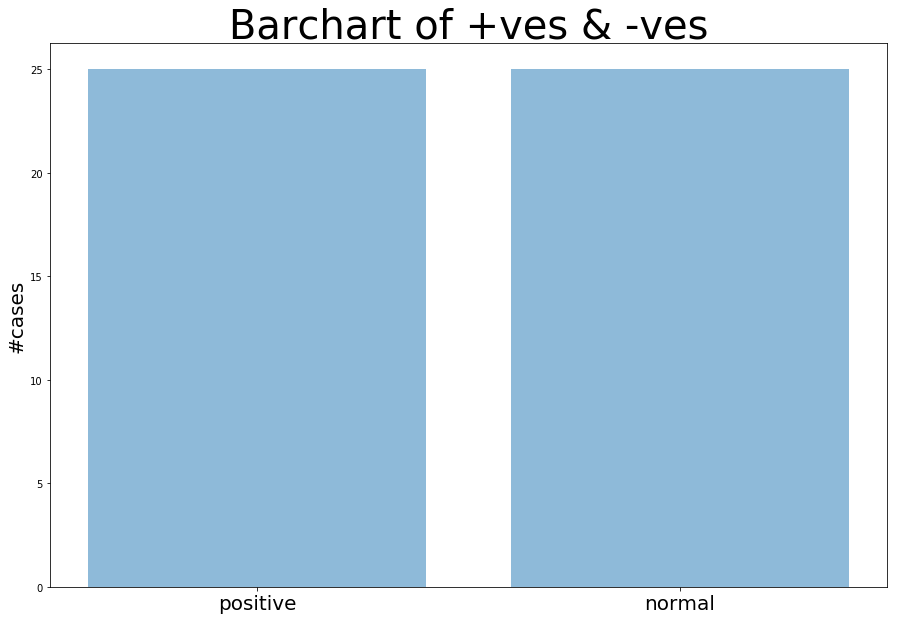

In [4]:
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
objects = ['positive', 'normal']
y_pos = np.arange(len(objects))
cases = [len(positive_file_dirs), len(negative_file_dirs)] 
plt.bar(y_pos, cases, align='center', alpha=0.5)
plt.xticks(y_pos, objects, fontsize = 20)
plt.ylabel('#cases', fontsize = 20)
plt.title('Barchart of +ves & -ves', fontsize = 40)
plt.show()

In [5]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
SIZE = len(positive_file_dirs) + len(negative_file_dirs)
CHANNELS = 3

### 1.2 Visualize positive examples

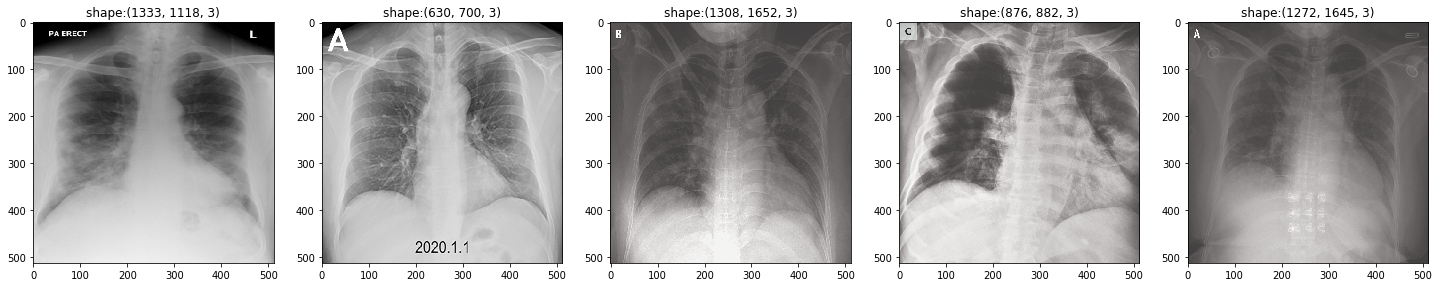

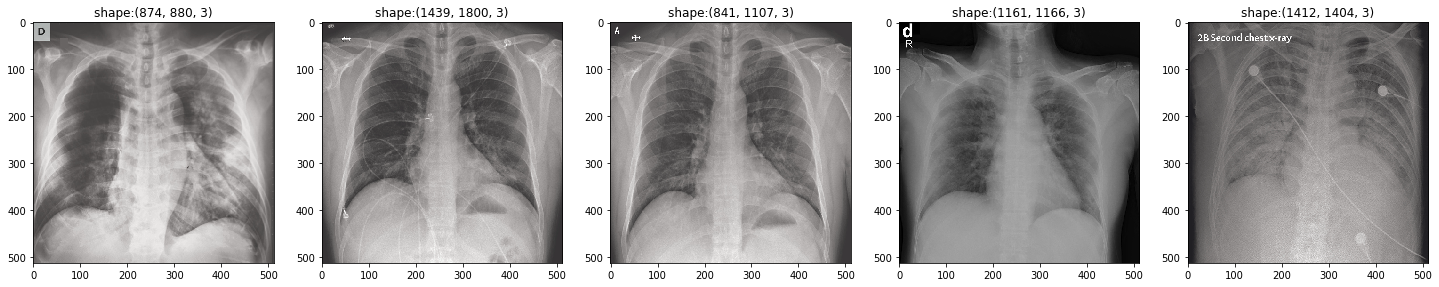

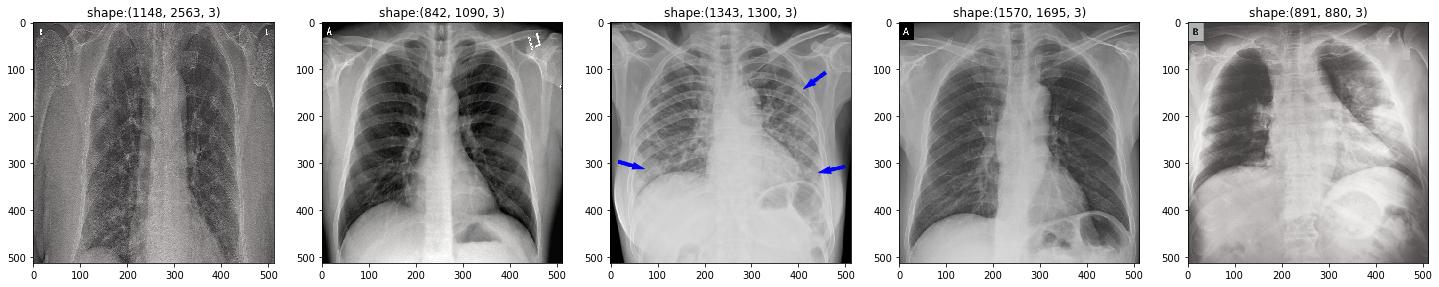

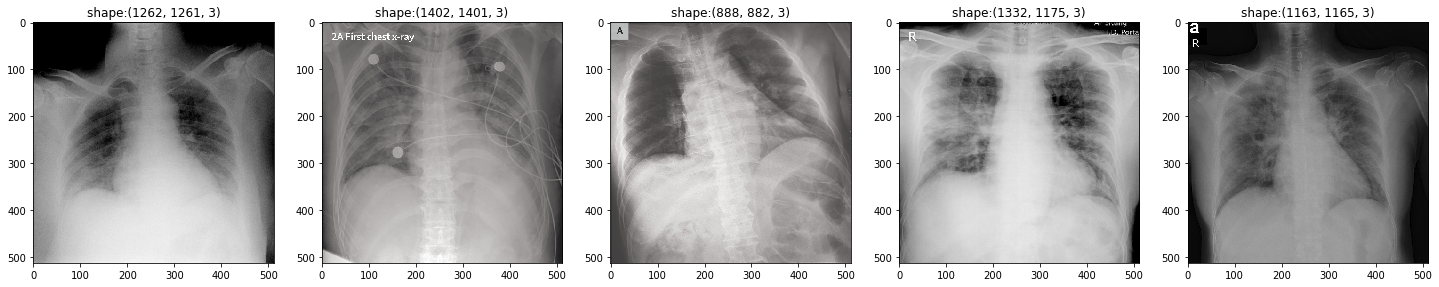

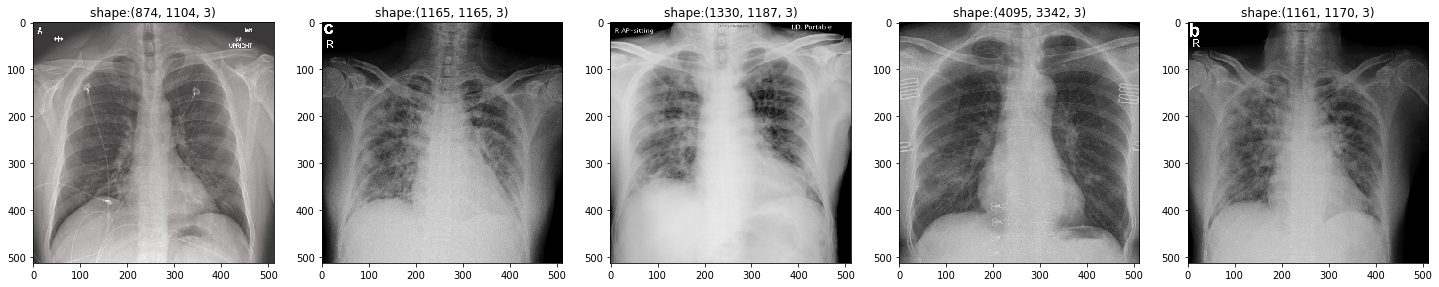

In [6]:
matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
for n, img_dir in enumerate(positive_file_dirs):
    plt.subplot(1,5,5-((n+1)%5))
    img = cv2.imread(img_dir)
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
    plt.imshow(img_resized)
    plt.title("shape:"+str(img.shape))
    if (n+1)%5==0:
        plt.show()

In [7]:
# matplotlib.rcParams['figure.figsize'] = (25.0, 5.0)
# for n, img_dir in enumerate(positive_file_dirs):
#     plt.subplot(1,5,5-((n+1)%5))
#     img = cv2.imread(img_dir)
#     dims = img.shape
#     pixel_matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
#     plt.hist2d(pixel_matrix[:,1], pixel_matrix[:,2], bins=(50,50))
#     if (n+1)%5==0:
#         plt.show()

### 1.3 Distribution of channels of positive examples

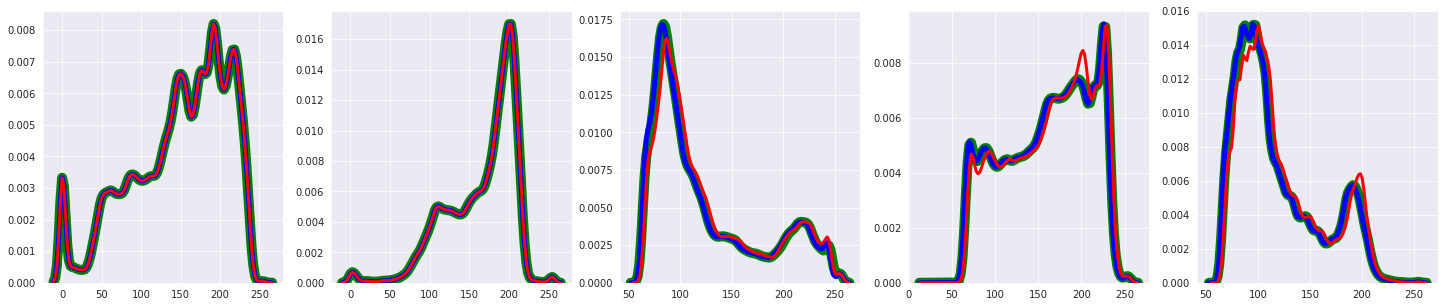

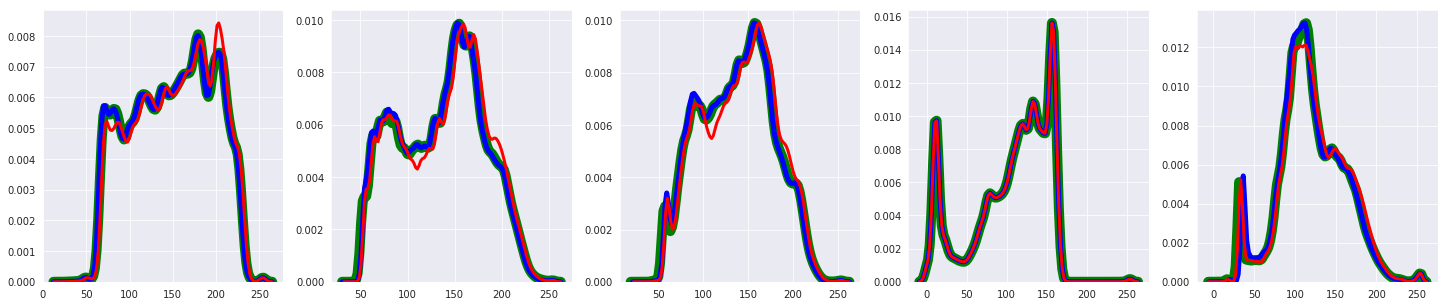

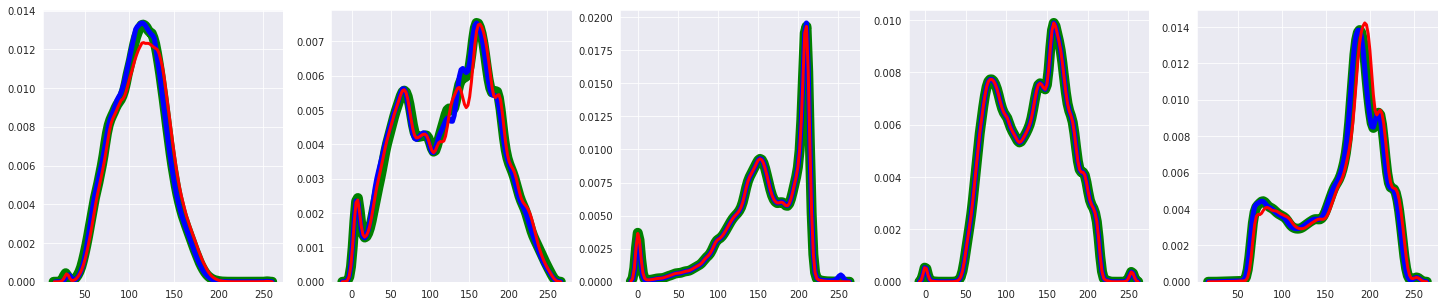

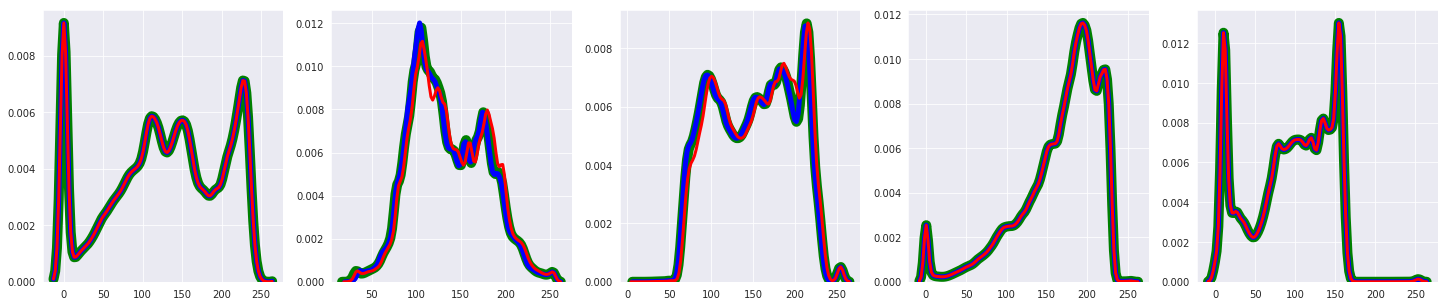

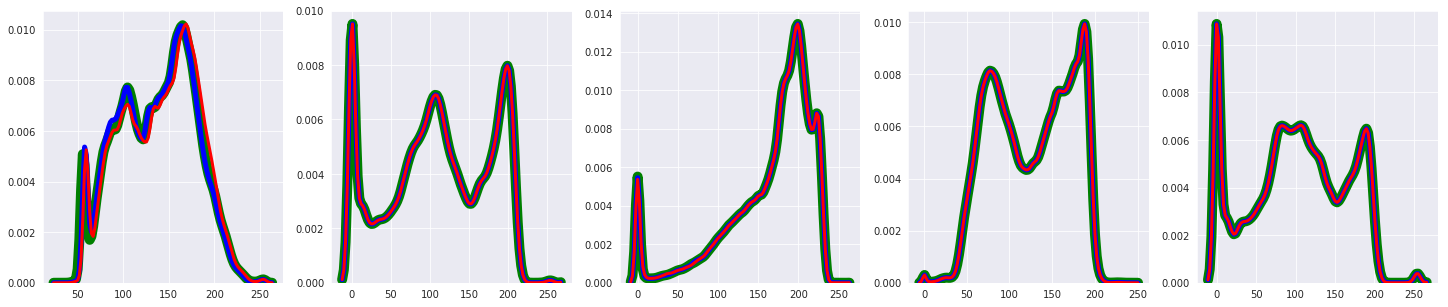

In [8]:
matplotlib.rcParams['figure.figsize'] = (25.0, 5.0)
sns.set_style("darkgrid")
for n, img_dir in enumerate(positive_file_dirs):
    plt.subplot(1,5,5-((n+1)%5))
    img = cv2.imread(img_dir)
    dims = img.shape
    pixel_matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
    sns.distplot(pixel_matrix[:,1], bins=50, hist=False, color = 'g',kde_kws=dict(linewidth=10))
    sns.distplot(pixel_matrix[:,2], bins=50, hist=False, color = 'b', kde_kws=dict(linewidth=5))
    sns.distplot(pixel_matrix[:,0], bins=50, hist=False, color = 'r', kde_kws=dict(linewidth=3))
    if (n+1)%5==0:
        plt.show()

### 1.4 Visualize negative examples

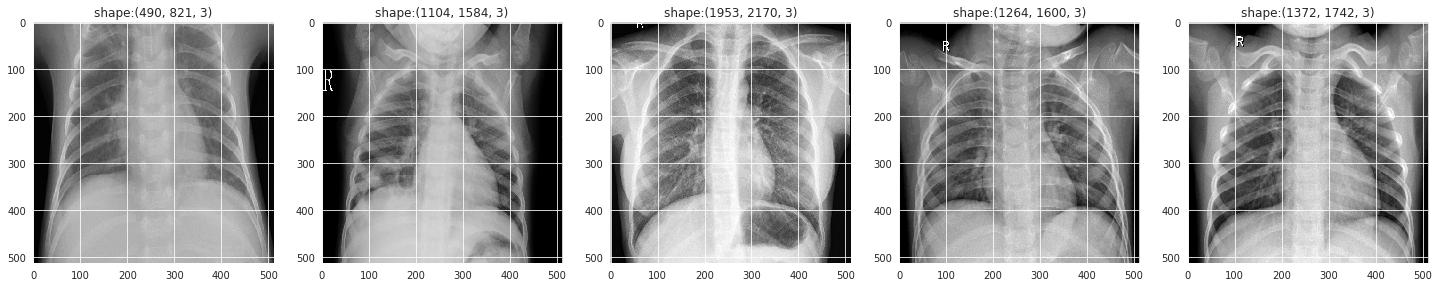

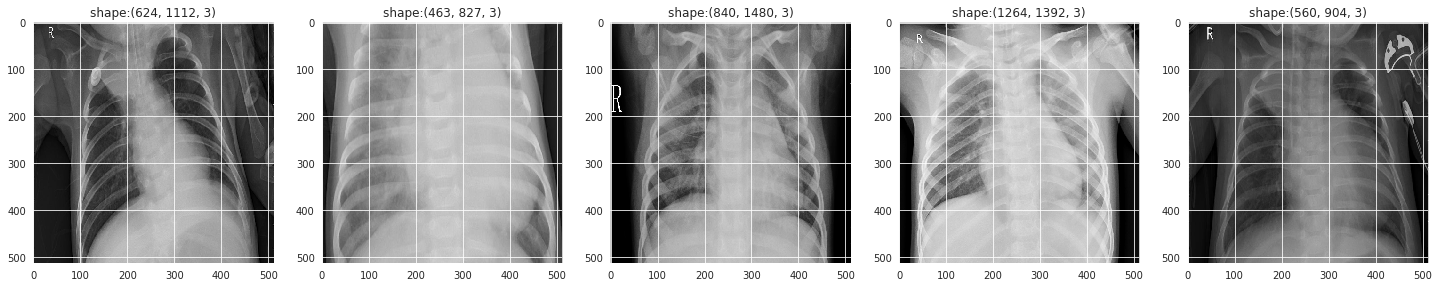

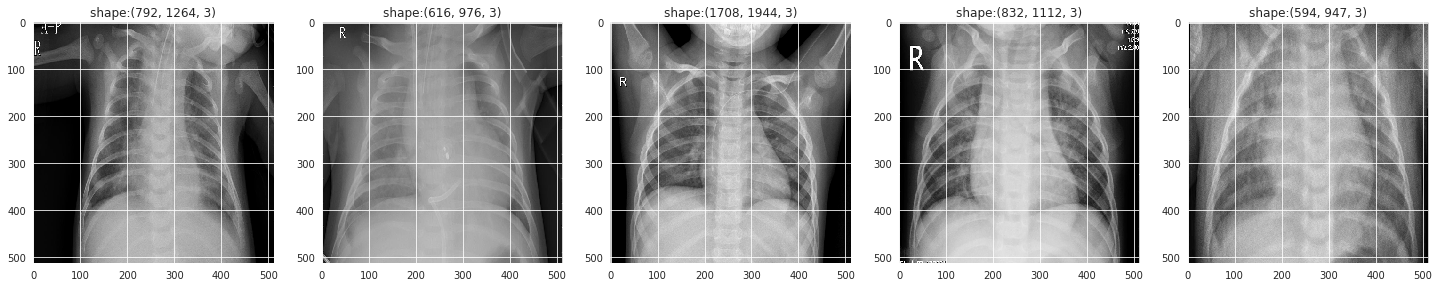

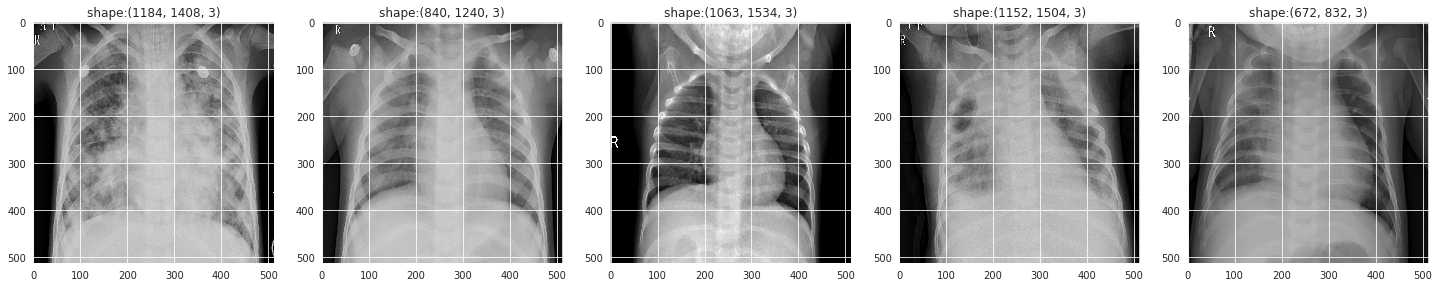

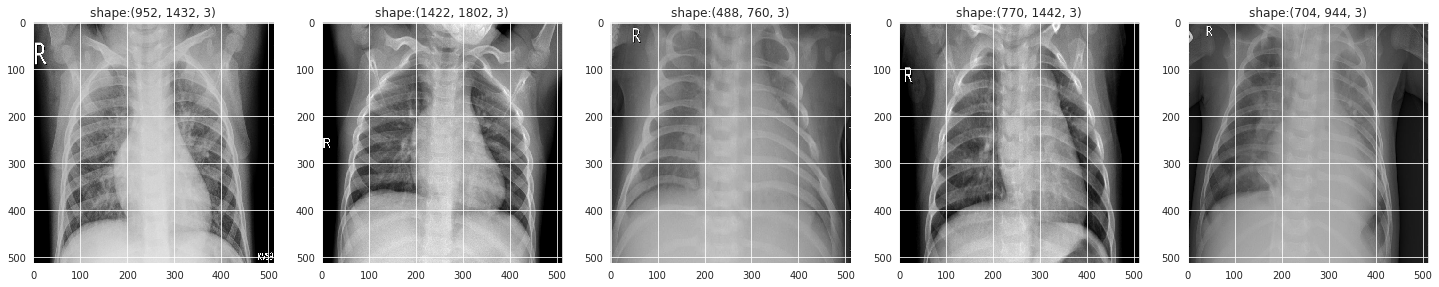

In [9]:
matplotlib.rcParams['figure.figsize'] = (25.0, 20.0)
for n, img_dir in enumerate(negative_file_dirs):
    plt.subplot(1,5,5-((n+1)%5))
    img = cv2.imread(img_dir)
    img_resized = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
    plt.imshow(img_resized)
    plt.title("shape:"+str(img.shape))
    if (n+1)%5==0:
        plt.show()

In [10]:
# matplotlib.rcParams['figure.figsize'] = (25.0, 5.0)
# for n, img_dir in enumerate(negative_file_dirs):
#     plt.subplot(1,5,5-((n+1)%5))
#     img = cv2.imread(img_dir)
#     dims = img.shape
#     pixel_matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
#     plt.hist2d(pixel_matrix[:,1], pixel_matrix[:,2], bins=(50,50))
#     if (n+1)%5==0:
#         plt.show()

### 1.5 Distribution of channels of negative examples

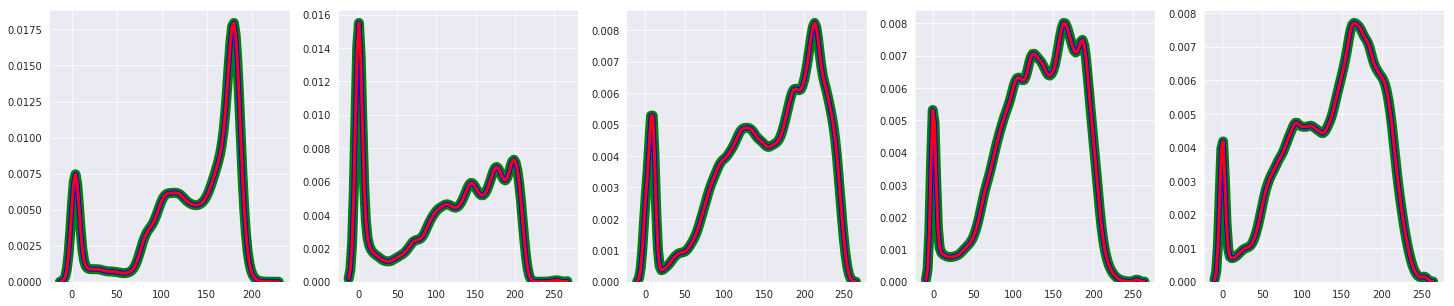

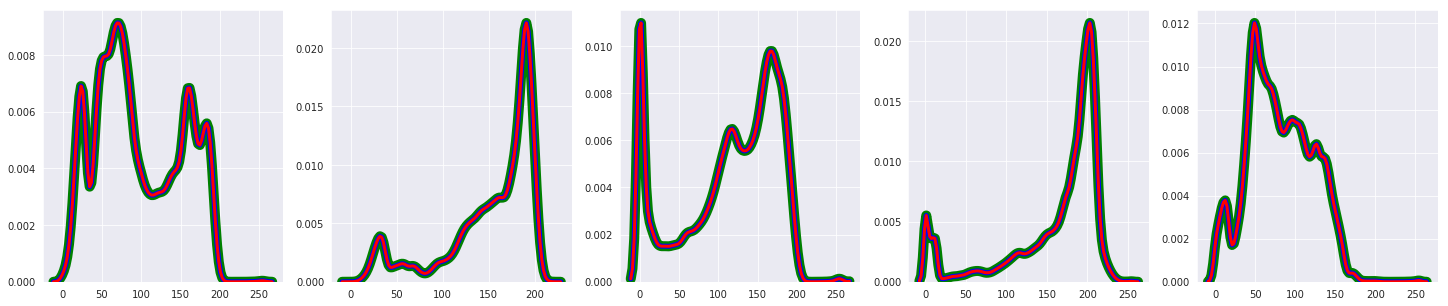

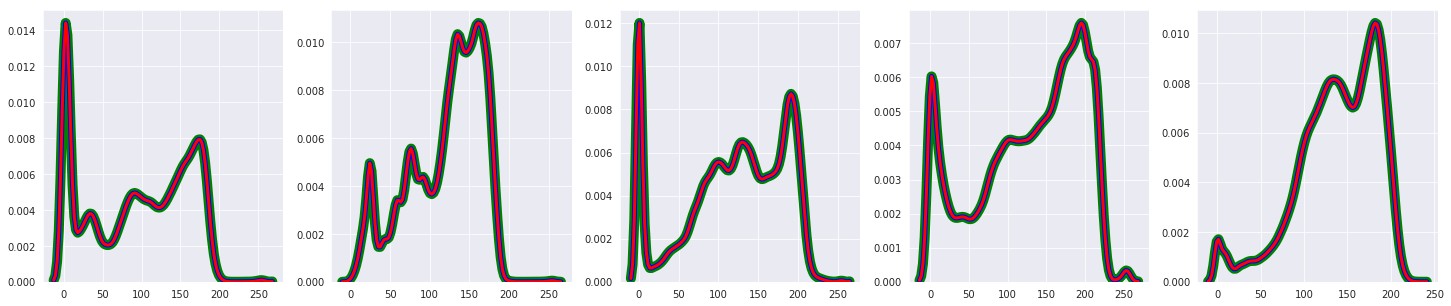

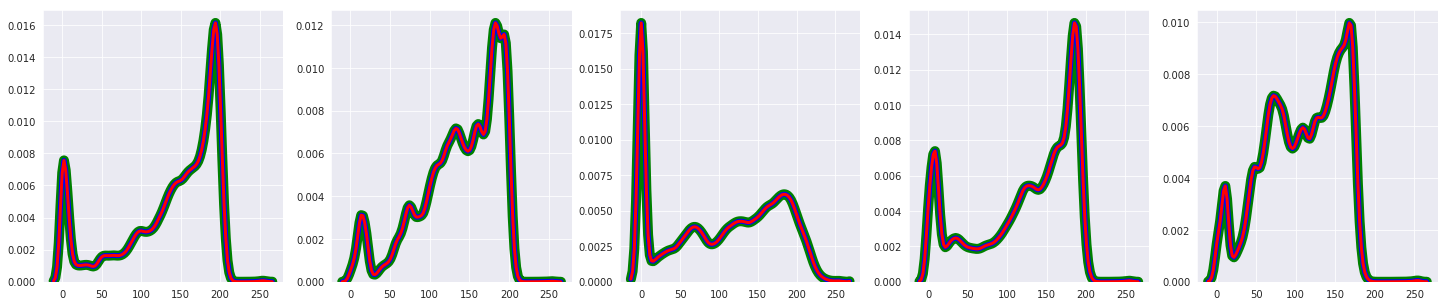

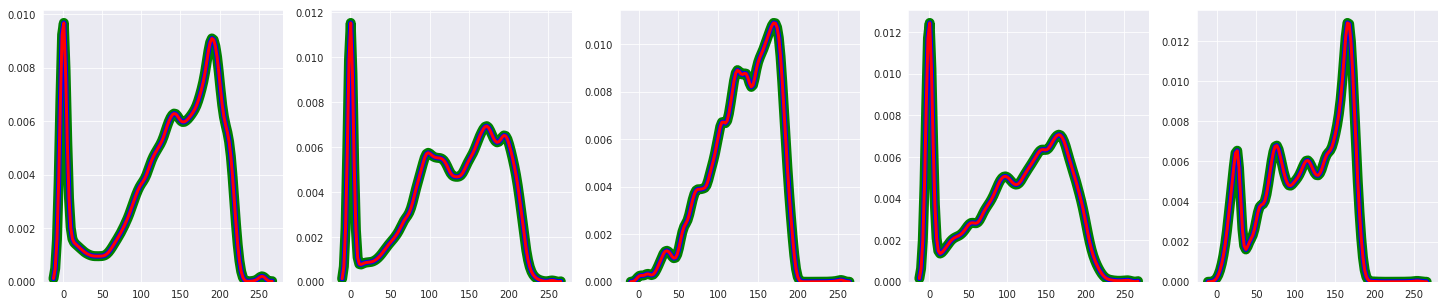

In [11]:
matplotlib.rcParams['figure.figsize'] = (25.0, 5.0)
sns.set_style("darkgrid")
for n, img_dir in enumerate(negative_file_dirs):
    plt.subplot(1,5,5-((n+1)%5))
    img = cv2.imread(img_dir)
    dims = img.shape
    pixel_matrix = np.reshape(img, (dims[0] * dims[1], dims[2]))
    sns.distplot(pixel_matrix[:,1], bins=50, hist=False, color = 'g',kde_kws=dict(linewidth=10))
    sns.distplot(pixel_matrix[:,2], bins=50, hist=False, color = 'b', kde_kws=dict(linewidth=5))
    sns.distplot(pixel_matrix[:,0], bins=50, hist=False, color = 'r', kde_kws=dict(linewidth=3))
    if (n+1)%5==0:
        plt.show()

## 2. Pretrained CNN model

### 2.1 Build pretrained resnet50 model

**Load pretrained resnet50 model without top**

In [12]:
resnet_50 = tf.keras.applications.ResNet50(include_top = False,input_shape = (512,512,3), pooling = 'avg')
resnet_50.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
__________________________

**Terminate the pretrained model with 2 dense layers**

In [13]:
model = tf.keras.Sequential((resnet_50, tf.keras.layers.Dense(128), tf.keras.layers.Dense(1, activation='sigmoid')))
for layer in model.layers:
    layer.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 23,850,113
Trainable params: 23,796,993
Non-trainable params: 53,120
_________________________________________________________________


### 2.2 Train pretrained model

**Create train & validation indices**

In [14]:
random.shuffle(positive_file_dirs)
random.shuffle(negative_file_dirs)
validation_split = 0.25
train_split = 1 - validation_split
train_size = int(round(train_split*SIZE, 0))
valid_size = SIZE - train_size
file_dirs_train = positive_file_dirs[:train_size//2] + negative_file_dirs[:train_size//2]
file_dirs_valid = positive_file_dirs[train_size//2:] + negative_file_dirs[train_size//2:]
random.shuffle(file_dirs_train)
random.shuffle(file_dirs_valid)
print("Train Size:", train_size)
print("Validation Size:", valid_size)

Train Size: 38
Validation Size: 12


**Create train data**

In [15]:
X_train = np.zeros(shape = (train_size, IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype = np.float32)
y_train = np.zeros(shape = (train_size,), dtype = np.int32)
for i in range(train_size):
    X_train[i] = cv2.resize(cv2.imread(file_dirs_train[i]), (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
    if file_dirs_train[i].split("/")[3] == "normal":
        y_train[i] = 0
    else:
        y_train[i] = 1

**Create validation data**

In [16]:
X_valid = np.zeros(shape = (valid_size, IMG_HEIGHT, IMG_WIDTH, CHANNELS), dtype = np.float32)
y_valid = np.zeros(shape = (valid_size,), dtype = np.int32)
for i in range(valid_size):
    X_valid[i] = cv2.resize(cv2.imread(file_dirs_valid[i]), (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_CUBIC)
    if file_dirs_valid[i].split("/")[3] == "normal":
        y_valid[i] = 0
    else:
        y_valid[i] = 1

**Compile model**

In [17]:
BATCH_SIZE = train_size//2
learning_rate = (1e-5)*1
optimizer = tf.keras.optimizers.Nadam(learning_rate= learning_rate)
model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
epochs = 300

**Train model**

In [18]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_keras_model.h5", monitor = 'val_loss', save_freq = BATCH_SIZE, save_best_only=True, mode = "min")
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs = epochs, validation_data = (X_valid, y_valid), callbacks=[checkpoint_cb])

Train on 38 samples, validate on 12 samples
Epoch 1/300
38/38 [==============================] - 26s 682ms/sample - loss: 0.9217 - accuracy: 0.4474 - val_loss: 0.7725 - val_accuracy: 0.4167
Epoch 2/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.6805 - accuracy: 0.5263 - val_loss: 0.7713 - val_accuracy: 0.3333
Epoch 3/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.5782 - accuracy: 0.6579 - val_loss: 0.7680 - val_accuracy: 0.3333
Epoch 4/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.4154 - accuracy: 0.9474 - val_loss: 0.7609 - val_accuracy: 0.5000
Epoch 5/300
38/38 [==============================] - 1s 30ms/sample - loss: 0.3154 - accuracy: 0.9474 - val_loss: 0.7524 - val_accuracy: 0.5000
Epoch 6/300
38/38 [==============================] - 1s 30ms/sample - loss: 0.2316 - accuracy: 1.0000 - val_loss: 0.7426 - val_accuracy: 0.5000
Epoch 7/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.1721 - accur

38/38 [==============================] - 1s 31ms/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.1691 - val_accuracy: 1.0000
Epoch 58/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.1661 - val_accuracy: 1.0000
Epoch 59/300
38/38 [==============================] - 1s 30ms/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1624 - val_accuracy: 1.0000
Epoch 60/300
38/38 [==============================] - 1s 30ms/sample - loss: 0.0075 - accuracy: 1.0000 - val_loss: 0.1591 - val_accuracy: 1.0000
Epoch 61/300
38/38 [==============================] - 1s 30ms/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.1562 - val_accuracy: 1.0000
Epoch 62/300
38/38 [==============================] - 1s 30ms/sample - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.1536 - val_accuracy: 1.0000
Epoch 63/300
38/38 [==============================] - 1s 33ms/sample - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1510 - val_accuracy: 1.000

38/38 [==============================] - 1s 32ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0780 - val_accuracy: 1.0000
Epoch 114/300
38/38 [==============================] - 1s 35ms/sample - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0759 - val_accuracy: 1.0000
Epoch 115/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.0738 - val_accuracy: 1.0000
Epoch 116/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0726 - val_accuracy: 1.0000
Epoch 117/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0716 - val_accuracy: 1.0000
Epoch 118/300
38/38 [==============================] - 1s 32ms/sample - loss: 9.4036e-04 - accuracy: 1.0000 - val_loss: 0.0706 - val_accuracy: 1.0000
Epoch 119/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.0696 - val_accur

38/38 [==============================] - 1s 30ms/sample - loss: 9.1545e-04 - accuracy: 1.0000 - val_loss: 0.0377 - val_accuracy: 1.0000
Epoch 169/300
38/38 [==============================] - 1s 32ms/sample - loss: 4.8643e-04 - accuracy: 1.0000 - val_loss: 0.0374 - val_accuracy: 1.0000
Epoch 170/300
38/38 [==============================] - 1s 32ms/sample - loss: 5.3423e-04 - accuracy: 1.0000 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 171/300
38/38 [==============================] - 1s 30ms/sample - loss: 4.9238e-04 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 1.0000
Epoch 172/300
38/38 [==============================] - 1s 31ms/sample - loss: 4.3927e-04 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 1.0000
Epoch 173/300
38/38 [==============================] - 1s 31ms/sample - loss: 6.0329e-04 - accuracy: 1.0000 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 174/300
38/38 [==============================] - 1s 31ms/sample - loss: 7.5113e-04 - accuracy: 1.0000 - val_

Epoch 223/300
38/38 [==============================] - 1s 31ms/sample - loss: 5.0254e-04 - accuracy: 1.0000 - val_loss: 0.0195 - val_accuracy: 1.0000
Epoch 224/300
38/38 [==============================] - 1s 30ms/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0192 - val_accuracy: 1.0000
Epoch 225/300
38/38 [==============================] - 1s 31ms/sample - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0187 - val_accuracy: 1.0000
Epoch 226/300
38/38 [==============================] - 1s 32ms/sample - loss: 5.3694e-04 - accuracy: 1.0000 - val_loss: 0.0185 - val_accuracy: 1.0000
Epoch 227/300
38/38 [==============================] - 1s 30ms/sample - loss: 9.5238e-04 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 228/300
38/38 [==============================] - 1s 30ms/sample - loss: 2.8285e-04 - accuracy: 1.0000 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 229/300
38/38 [==============================] - 1s 31ms/sample - loss: 4.5876e-04 - accuracy: 1.0000 

Epoch 278/300
38/38 [==============================] - 1s 31ms/sample - loss: 8.4692e-04 - accuracy: 1.0000 - val_loss: 0.0100 - val_accuracy: 1.0000
Epoch 279/300
38/38 [==============================] - 1s 30ms/sample - loss: 3.9524e-04 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 280/300
38/38 [==============================] - 1s 31ms/sample - loss: 1.7332e-04 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 281/300
38/38 [==============================] - 1s 31ms/sample - loss: 2.0792e-04 - accuracy: 1.0000 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 282/300
38/38 [==============================] - 1s 31ms/sample - loss: 3.5888e-04 - accuracy: 1.0000 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 283/300
38/38 [==============================] - 1s 30ms/sample - loss: 3.3829e-04 - accuracy: 1.0000 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 284/300
38/38 [==============================] - 1s 31ms/sample - loss: 3.1186e-04 - accuracy:

## 3. Visualize Results

**Collect history**

In [19]:
history_dict = history.history
keys = history_dict.keys()
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

### 3.1 Plot of Loss vs Epochs

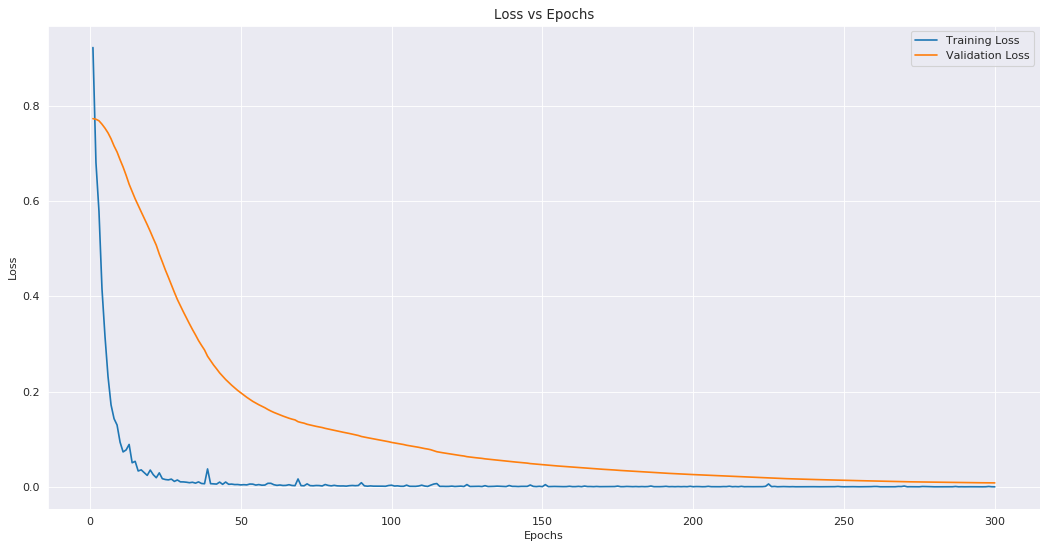

In [20]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss,  label='Training Loss')
plt.plot(epochs, val_loss,  label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 3.2 Plot of Accuracy vs Epochs

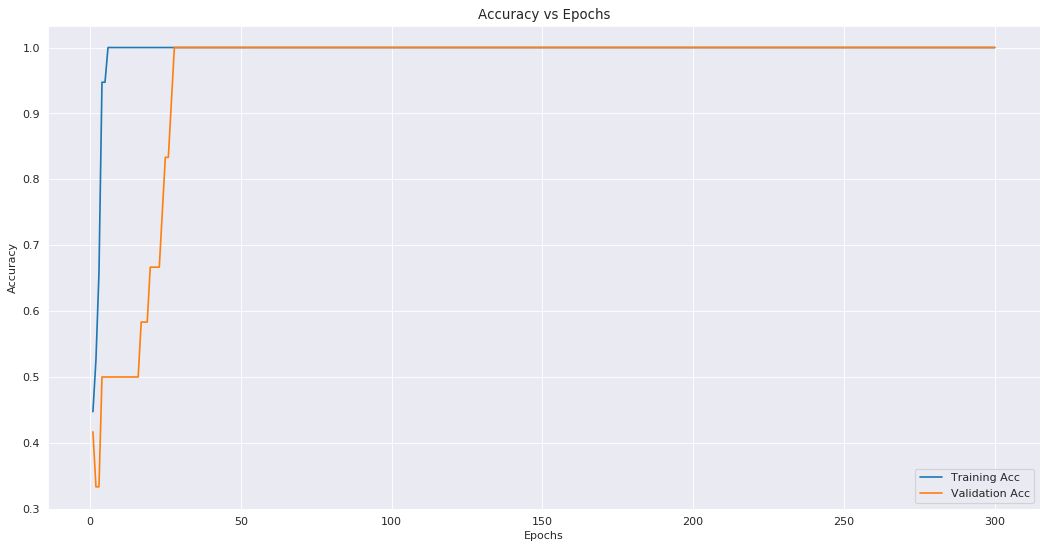

In [21]:
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc,  label='Training Acc')
plt.plot(epochs, val_acc,  label='Validation Acc')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### 3.3 Visualize all positive and negative examples using TSNE

In [22]:
X = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))

In [23]:
pos_indices = np.where(y==1)[0]
neg_indices = np.where(y==0)[0]

In [24]:
X_embedded = TSNE(n_components=2).fit_transform(resnet_50.predict(X))
X_embedded_positive = X_embedded[pos_indices]
X_embedded_negative = X_embedded[neg_indices]

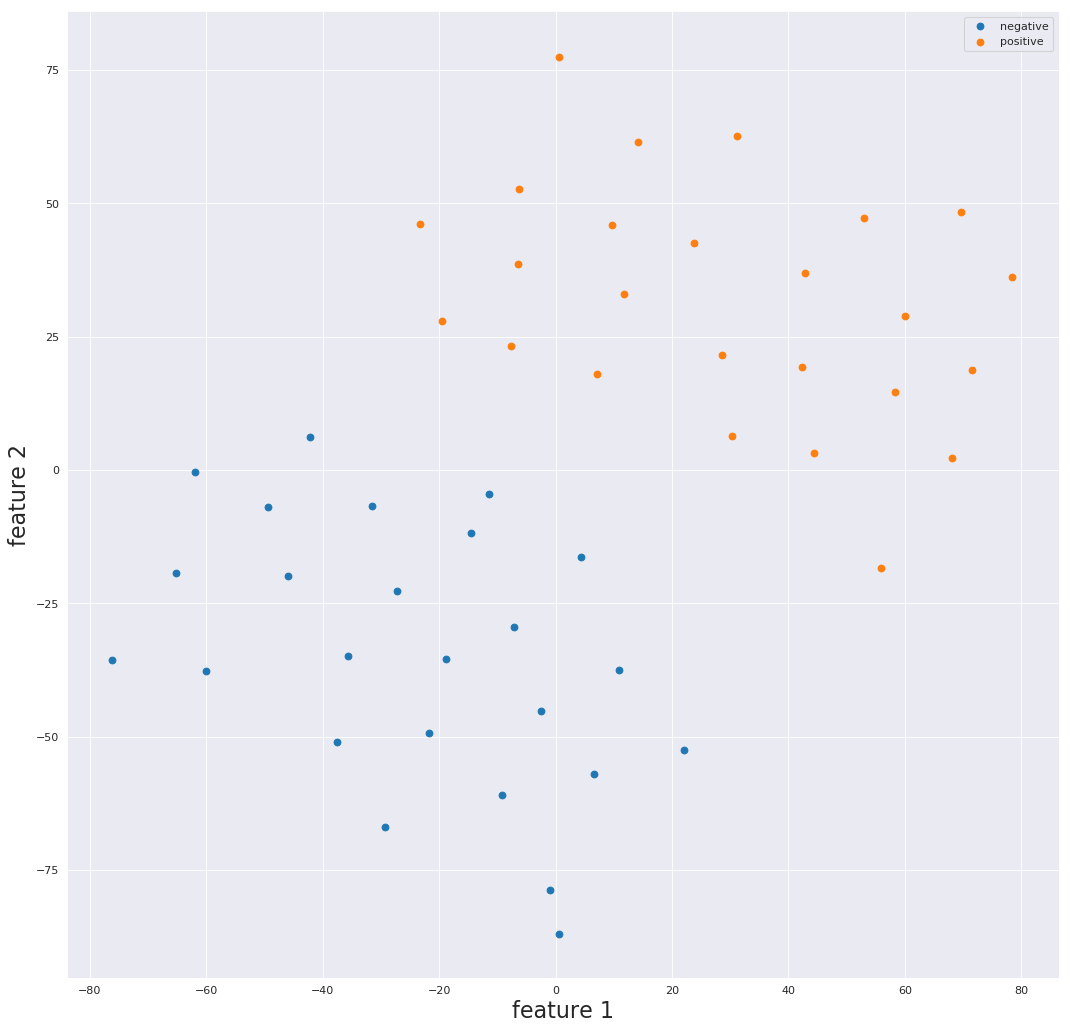

In [25]:
plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(X_embedded_negative[:,0], X_embedded_negative[:,1], label = 'negative')
plt.scatter(X_embedded_positive[:,0], X_embedded_positive[:,1], label = 'positive')
plt.xlabel('feature 1', fontsize = 20)
plt.ylabel('feature 2', fontsize = 20)
plt.legend()
plt.grid(True)
plt.show()

### 3.4 Confusion Matrix

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

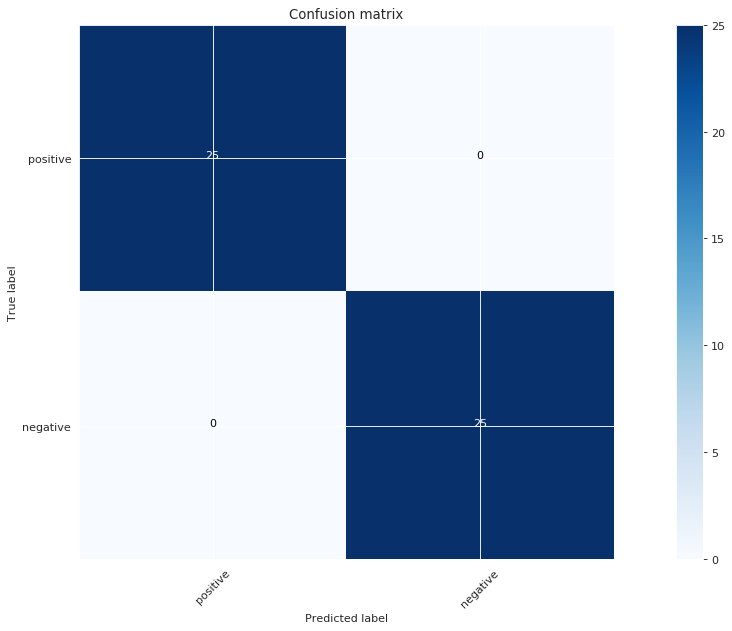

In [27]:
y_ = np.round(model.predict(X)).flatten()
index2label = {0:"negative", 1:"positive"}
y_true = [index2label[pred] for pred in y]
y_pred = [index2label[pred] for pred in y_]
cnf_matrix = confusion_matrix(y_true, y_pred,labels=['positive', 'negative'])
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plot_confusion_matrix(cnf_matrix, classes=['positive', 'negative'],title='Confusion matrix')